# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec
import sklearn.metrics as metrics
#auto correlacion
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#descomposicion de serie
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#Prophet
#from prophet import Prophet
#from prophet.plot import plot_plotly, plot_components_plotly

import matplotlib

In [2]:
#data_2020 = pd.read_csv('/content/sample_data/flujo-vehicular-2020.csv', sep =',')
data_2019 = pd.read_csv(r'flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv(r'flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv(r'flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

In [6]:
#unimos los ds para poder hacer un EDA inicial
#union para dataset de trabajo.
dataset = pd.concat([data_2019, data_2018, data_2017])
#union en arreglo para graficos
datasets=[data_2017,data_2018,data_2019] #parafunciones

<AxesSubplot:xlabel='fecha'>

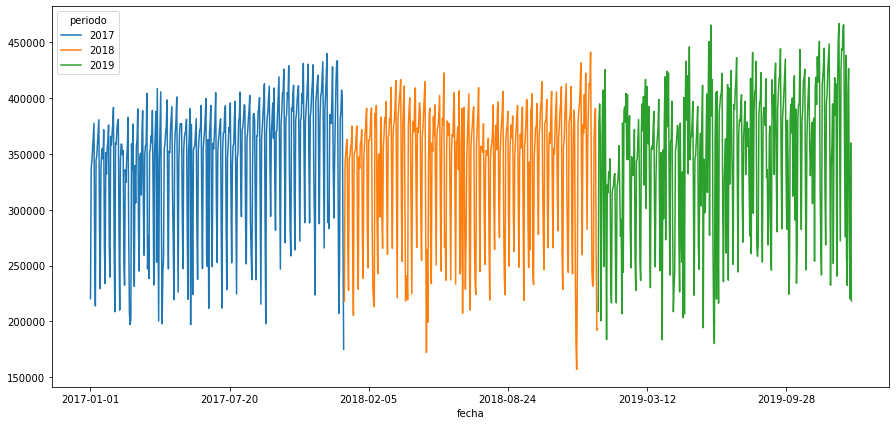

In [7]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
dataset.groupby(['fecha','periodo']).sum()['cantidad_pasos'].unstack().plot(ax=ax)

Millones de pasadas por año.

Para el año 2017 la cantidad de pasadas ocurridas en las autopistas de AUSA fueron de 124 millones para el año 2017, 123 millones para el año 2018 y 126 millones para el año 2019. Esto representa un crecimiento de un 2.92% del 2019 respecto del 2018. Tambien se nota una caida del pasadas el año 2017 de -1.5% respecto del 2017.






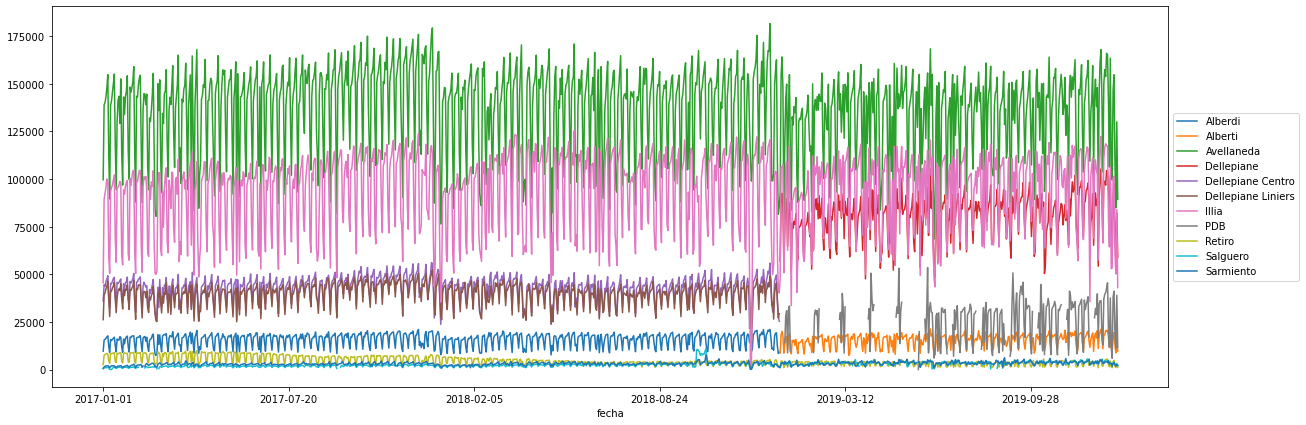

In [8]:
# plot data
fig, ax = plt.subplots(figsize=(20,7))
# use unstack()
dataset.groupby(['fecha','estacion']).sum()['cantidad_pasos'].unstack().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Podemos observar que para fines del año 2018 las autopistas Liniers y Centro dejaron de tener flujo, derivando a PDB y Dellepiane. Tambien podemos observar que el flujo de Sarmiento converge enAlberti a contar del año 2019.

In [9]:
dataset.groupby(['periodo','estacion'])['cantidad_pasos'].agg('sum').round()

periodo  estacion          
2017     Alberdi                5789514
         Avellaneda            50811590
         Dellepiane Centro     15880444
         Dellepiane Liniers    14813490
         Illia                 33570584
         Retiro                 2352828
         Salguero                616828
         Sarmiento               998212
2018     Alberdi                5734842
         Avellaneda            49652369
         Dellepiane Centro     15407755
         Dellepiane Liniers    14355089
         Illia                 34490038
         Retiro                 1398682
         Salguero                952055
         Sarmiento              1102862
2019     Alberti                5631401
         Avellaneda            48303625
         Dellepiane            29295448
         Illia                 34155167
         PDB                    5668376
         Retiro                 1170450
         Salguero               1221380
         Sarmiento              1264678
Name: cantid

<AxesSubplot:xlabel='periodo'>

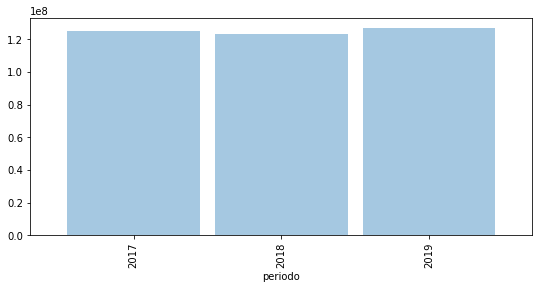

In [10]:
dataset.groupby(['periodo'])['cantidad_pasos'].agg('sum').plot(kind='bar', alpha = 0.4, width = 0.9, figsize=(9,4))

En tanto 

In [11]:
def pareto_cantidad_pasos(column:str,pareto_line=True,figsize_g=(16,8),grid=True):

    plt.figure(figsize=figsize_g)
    for idx,dataset in enumerate(datasets):
        conteo_estacion = dataset.groupby(by=column).agg('sum')[['cantidad_pasos']].sort_values(by='cantidad_pasos',ascending=False)          
        conteo_estacion["cumpercentage"] = conteo_estacion['cantidad_pasos'].cumsum()/conteo_estacion['cantidad_pasos'].sum()*100
        
        plt.subplot(2,2,idx+1)
        conteo_bar=sns.barplot(x=conteo_estacion.index,y='cantidad_pasos',data=conteo_estacion)
       
        plt.xticks(rotation=45,ha='right')
        if pareto_line==True:
            ax2=plt.twinx() #auto escalado de la figura
            ax2.plot(conteo_estacion.index,conteo_estacion["cumpercentage"],color="#ff5400",marker='D',ms=7)
            ax2.yaxis.set_major_formatter(PercentFormatter())     
            ax2.tick_params(axis="y", colors="#ff5400")
        for p in conteo_bar.patches: 
            conteo_bar.annotate(format(p.get_height(), ',.0f'), 
                                (p.get_x() + p.get_width() / 2., p.get_height()), 
                                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
        plt.title(f'{2017+idx}',fontweight='bold')   
        sns.despine()
        if grid == True:
            plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

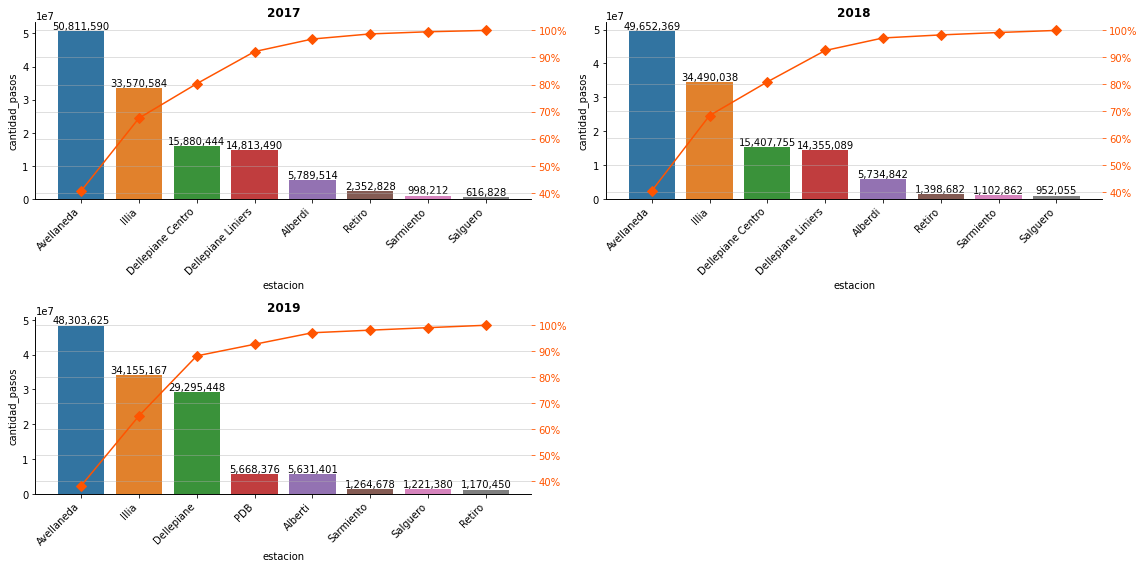

In [12]:
pareto_cantidad_pasos('estacion')

Inicialmente observamos que Avellanenda, Illia y Dellapiane son las autopistas que concentran el 80% de trafico tanto para el 2017 y 2018. Para el año 2019 se encuentran cernas al 90% donde Dellapiane duplica su trafico en comparacion a los años atenriores lo que explicaria el alza agrupar Centro y Liniers ya que el flujo para el año 2019 se redujo en comparacion al año anterior.

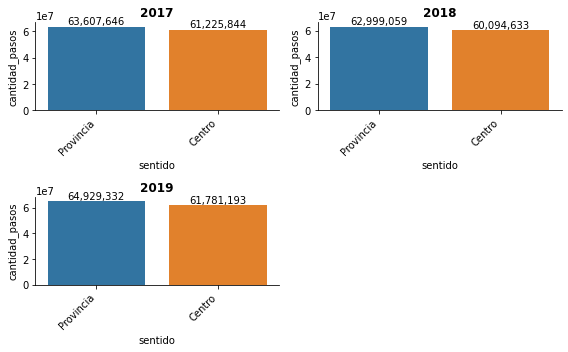

In [13]:
pareto_cantidad_pasos(column='sentido',
                      pareto_line=False, figsize_g=(8, 5), grid=False)

En cuanto al flujo por sentido podemos observar que este es relativamente balanceado, siende en general los viajes a privincia mayores que el flujo al centro.

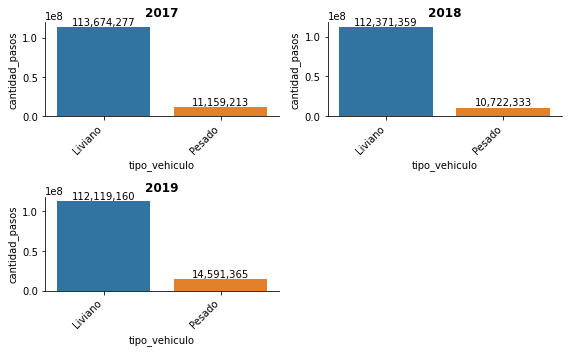

In [14]:
pareto_cantidad_pasos(column='tipo_vehiculo',
                      pareto_line=False, figsize_g=(8, 5), grid=False)

Podemos obvservar que el flujo de vehiculos livianos predomina sobre los de carga peseda.

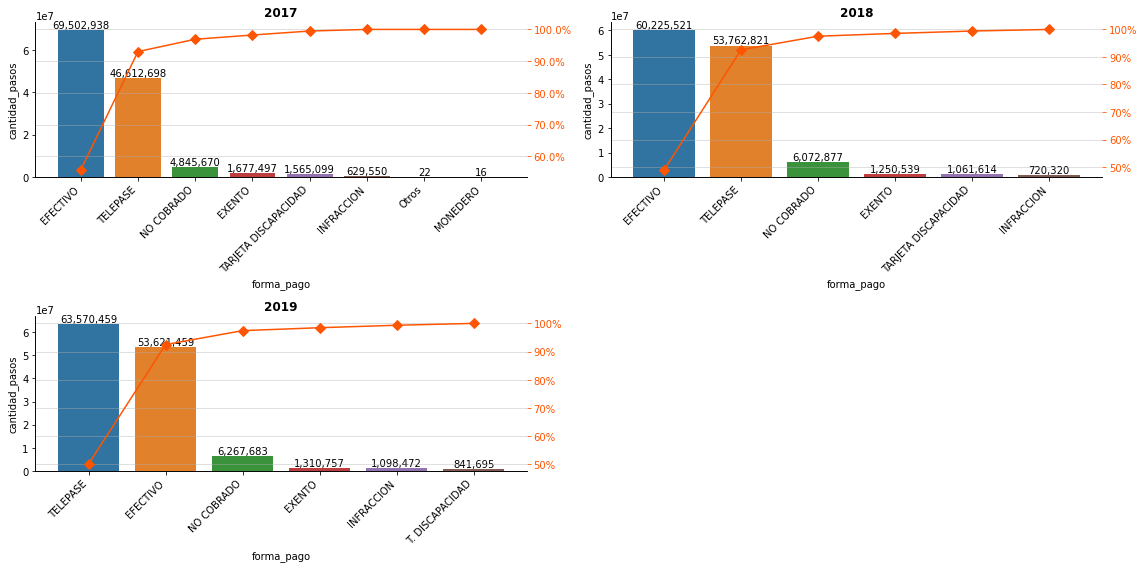

In [15]:
pareto_cantidad_pasos(column='forma_pago')

En cuanto a las formas de pago podemos destacar que el motodo de pago en efectivo pierde popularidad frente al metodos de pago electronicos como el telepase o futuro TAG. Para el año 2019 estos pagos. 

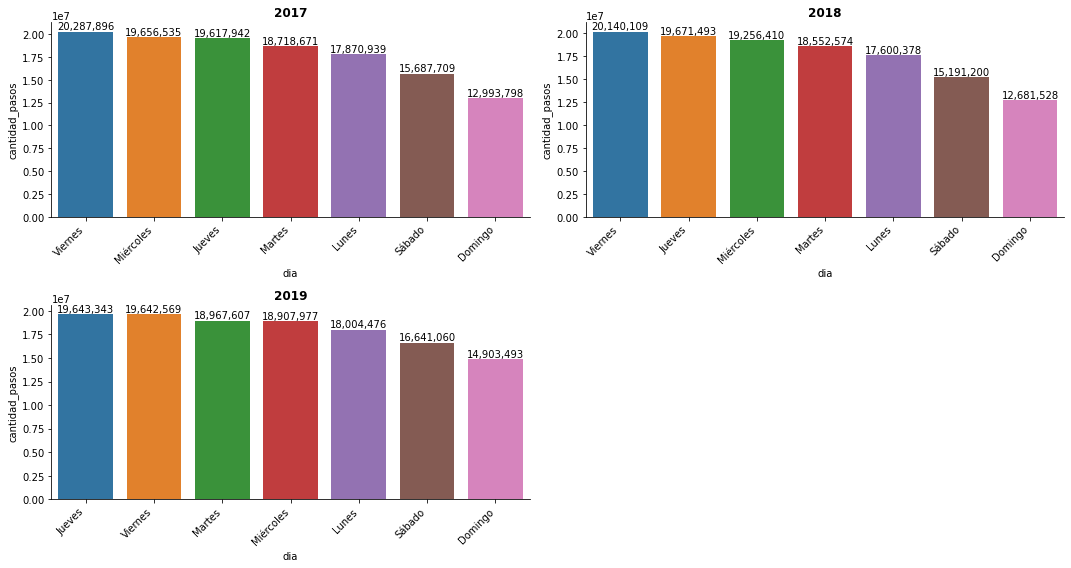

In [16]:
pareto_cantidad_pasos(column='dia',
                      pareto_line= False, figsize_g=(15, 8), grid=False)

Por otro lado el flujo vehicular se concentra principalmente en los dias laborales, siendo los dias sabado y domingo los de menor flujo para el 2017, 2018 y 2019.

# Datos de trabajo recomendados.
## filtrado de datos

  Se establecen filtros por autopista Illia y formas de pago en efectivo, ademas dejamos fuera por ahora variables 'periodo','hora_inicio','forma_pago', 'estacion'

In [17]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]
#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

In [18]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [19]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

In [20]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)

In [21]:
dataset = dataset.set_index('fecha')

In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 238869 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   dia             238869 non-null  object
 1   sentido         238869 non-null  object
 2   tipo_vehiculo   238869 non-null  object
 3   cantidad_pasos  238869 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.1+ MB


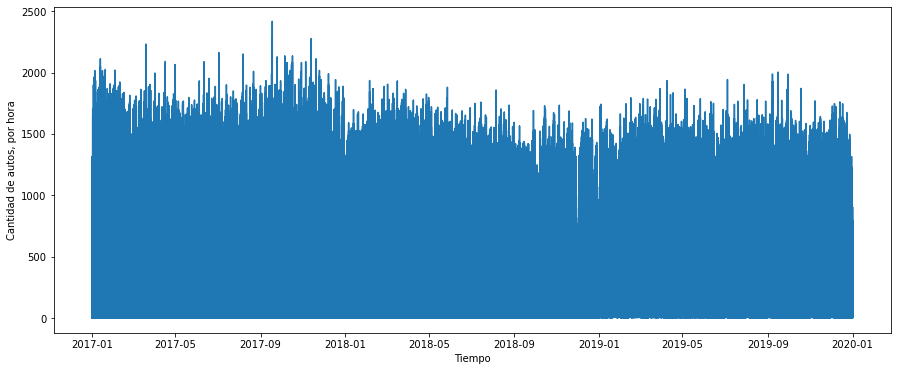

In [23]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.index, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [24]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [25]:
semanal = dataset.resample('W').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [26]:
mensual = dataset.resample('M').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


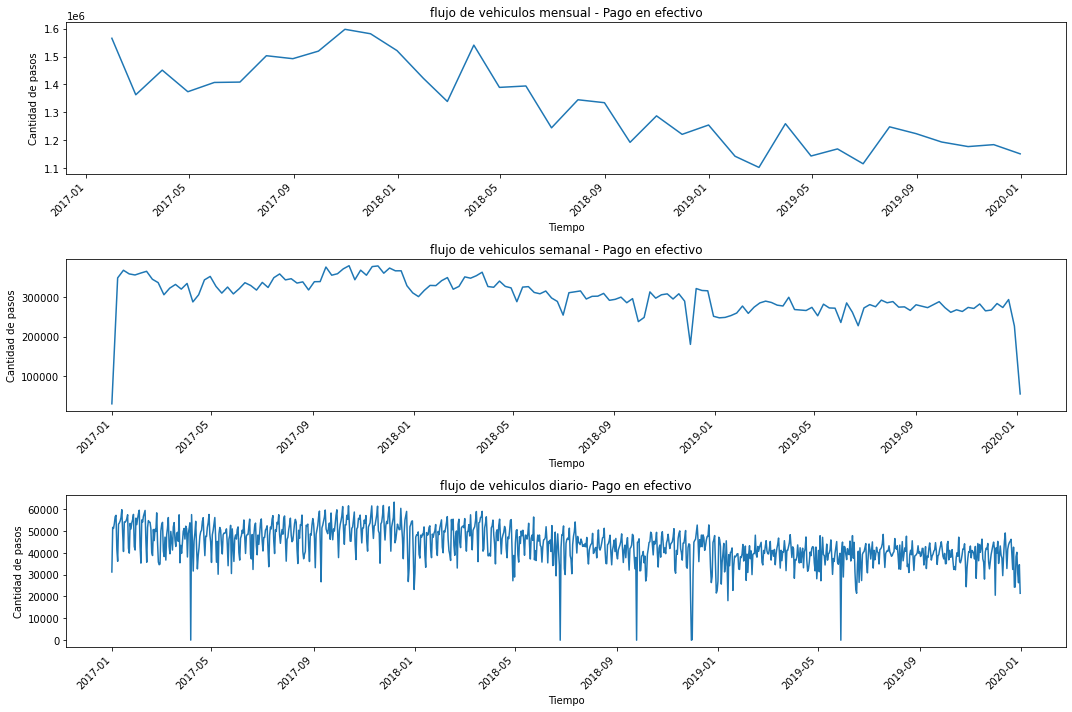

In [27]:
plt.figure(figsize = (15,10))

plt.subplot(3,1,1)
plt.title('flujo de vehiculos mensual - Pago en efectivo') 
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xticks(rotation=45,ha='right')

plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,2)
plt.title('flujo de vehiculos semanal - Pago en efectivo') 
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xticks(rotation=45,ha='right')

plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')


plt.subplot(3,1,3)
plt.title('flujo de vehiculos diario- Pago en efectivo') 
plt.plot(diario.index, diario.cantidad_pasos)
plt.xticks(rotation=45,ha='right')

plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')


plt.tight_layout()
plt.show()


Cuando observamos el flujo vehicular de manera mensual es posible destacar una tendencia a la baja del pago en efectivo para la autopista Lillia.

Si utilizamos una frecuencia diaria encontramos algunos datos cercanos a cero, es decir que en aquellos dias se produjieron cero cobros en efectivo en autpista Lillia.

Por ello daremos una Zoom a estos datos para evualar su tratamiento.

# OUTLIERS / ATIPICOS

In [28]:
diario.cantidad_pasos.isnull().sum()

0

No se notan datos nulos.

In [29]:
diario.describe().round(3)

,cantidad_pasos
count,1095.000
mean,43712.859
std,8192.737
min,0.000
25%,39061.500
50%,43761.000
75%,49498.000
max,63127.000


El promedio de viajes en esta atopista esta cercano a los 43.712 pases diarios, sin embargo podemos utlizar un Modelo IQR en resampleo diario para evaluar algunos margenes de transito diaria para el tratamiento de datos atipicos.

In [30]:
def IQR(dataset):
    IQR = np.quantile(dataset.cantidad_pasos,0.75)-np.quantile(dataset.cantidad_pasos,0.25)
    limite_sup = np.quantile(dataset.cantidad_pasos,0.75) + 1.5*IQR
    limite_inf = np.quantile(dataset.cantidad_pasos,0.25) - 1.5*IQR
    return {'IQR':IQR, 'limite_sup':limite_sup, 'limite_inf':limite_inf}

In [31]:
#indicamos el dataset donde aplicamos la funcion
results_iqr_diario = IQR(diario)
IQR_diario = results_iqr_diario['IQR']
limite_sup_diario = results_iqr_diario['limite_sup']
limite_inf_diario = results_iqr_diario['limite_inf']
print('IQR diario')
print(results_iqr_diario)

IQR diario
{'IQR': 10436.5, 'limite_sup': 65152.75, 'limite_inf': 23406.75}


In [32]:
print('Cantidad de puntos por encima del límite superior:',diario[diario.cantidad_pasos>limite_sup_diario].shape[0])
print('Cantidad de puntos por debajo del límite inferior:',diario[diario.cantidad_pasos<limite_inf_diario].shape[0])
print(diario[diario.cantidad_pasos<limite_inf_diario])

Cantidad de puntos por encima del límite superior: 0
Cantidad de puntos por debajo del límite inferior: 16
            cantidad_pasos
fecha                     
2017-04-06              40
2017-12-31           23229
2018-06-25               0
2018-09-25               0
2018-11-29           19728
2018-11-30               0
2018-12-01             350
2018-12-30           21559
2018-12-31           22599
2019-01-13           18076
2019-01-19           22774
2019-05-29               0
2019-06-16           23190
2019-06-17           21469
2019-12-01           20553
2019-12-31           21447


En este caso se establece que el limite inferior diario esta cercano a los 23.406 pases diarios, practicamente la mitad del promedio diario, ademas nos indica que los valor por fuera del rango son 16.

Observamos que los datos atipicos aun estan muy fuera de esos limites y tambien podemos determinar que para la serie de tiempo analizada son relativamente irrelevantes, pos tanto utilizaremos 

In [33]:
#10 días de mayor flujo vehicular
print('Dias de menor flujo')
print(diario.sort_values(by='cantidad_pasos',ascending=True).head(16))
print('Dias de mayor flujo')
print(diario.sort_values(by='cantidad_pasos',ascending=False).head(16))

Dias de menor flujo
            cantidad_pasos
fecha                     
2018-06-25               0
2018-09-25               0
2018-11-30               0
2019-05-29               0
2017-04-06              40
2018-12-01             350
2019-01-13           18076
2018-11-29           19728
2019-12-01           20553
2019-12-31           21447
2019-06-17           21469
2018-12-30           21559
2018-12-31           22599
2019-01-19           22774
2019-06-16           23190
2017-12-31           23229
Dias de mayor flujo
            cantidad_pasos
fecha                     
2017-12-07           63127
2017-11-24           61594
2017-10-13           61421
2017-11-10           61382
2017-11-17           61259
2017-10-06           61099
2017-12-01           60985
2017-12-15           60280
2017-01-13           59651
2017-09-29           59604
2017-09-15           59496
2017-02-03           59423
2017-02-10           59319
2017-09-08           59010
2018-03-23           58905
2017-12-22     

### Que sabemos de algunas fechas. 
    
    -2017-04-06: Paro General.

    -2018-06-25: Paro General.

    -2018-09-25: Paro General.

    -2018-11-30: Cumbre G20.

    -2018-12-01: Cumbre G20.

    -2019-05-29: Paro General.

In [34]:
#todos los valores por debajo de la norma seran expuesto por NAN para luego ser remplazados.
diario.cantidad_pasos[diario.cantidad_pasos < 10000] = np.nan 
diario['cantidad_pasos'] = diario.cantidad_pasos.fillna(diario.cantidad_pasos.rolling(4,min_periods=1).mean())

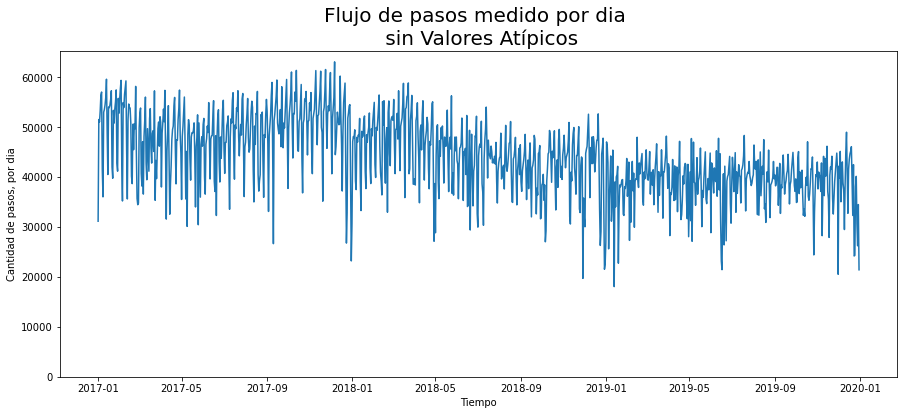

In [35]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.title("Flujo de pasos medido por dia \n sin Valores Atípicos", fontsize= 20)
plt.xlabel('Tiempo',)
plt.ylabel('Cantidad de pasos, por dia',)
plt.ylim(ymin=0)
plt.show()

In [36]:
#tres años, diario. ventana creada
#Center, me pone nulos al principio y al final.
ventana = int(365*3/30)
print(ventana)
diario_promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()
diario_promedio_tendencia

36


fecha
2017-01-01   NaN
2017-01-02   NaN
2017-01-03   NaN
2017-01-04   NaN
2017-01-05   NaN
              ..
2019-12-27   NaN
2019-12-28   NaN
2019-12-29   NaN
2019-12-30   NaN
2019-12-31   NaN
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

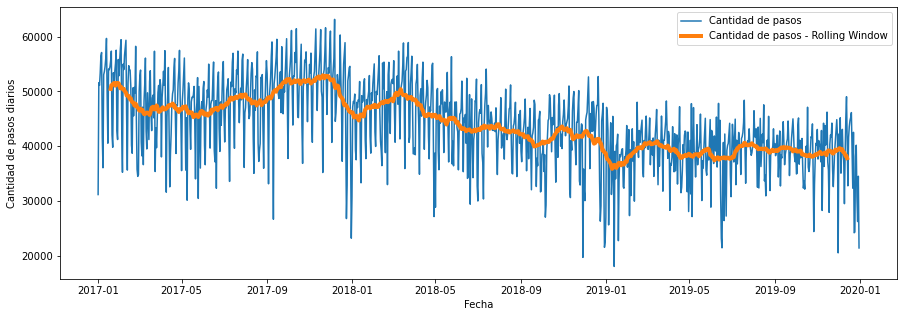

In [37]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de pasos')
plt.plot(diario_promedio_tendencia, lw = 4, label = 'Cantidad de pasos - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos diarios')
plt.legend()
plt.show()

Si aplicamos media movil podemos ratificar la tendencia a la baja de nuestra serie en el tiempo. Al parecer existen razones para creer que el pago en efectivo va de salida.

# Estacionalidad

In [38]:
X = diario.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=47957.060219, mean2=39887.636197
variance1=49186324.801524, variance2=32045450.781521


Podemos observar que la media de nuestros datos son muy similares sin embargo cuando observamos la varianza podemos detectar que la diferencia no es estadisitcamente significativa por lo que podemos creer que estamos hablando de una serie de tiempo  Estacionaria.

#### Test Dickey Fuller

Ho: La serie es no estacionaria

H1: La serie es estacionaria

In [39]:
from statsmodels.tsa.stattools import adfuller
X = diario.cantidad_pasos
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.708050
p-value: 0.426970
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


    Valor p> 0.05 : No se rechaza la hipótesis nula (H0), los datos tienen una raíz unitaria y no son estacionarios.
    p-value <= 0.05 : Rechaza la hipótesis nula (H0), los datos no tienen raíz unitaria y son estacionarios.
    
    Imprime el valor de la estadística de prueba de -4. Cuanto más negativa sea esta estadística, es más probable que rechacemos la hipótesis nula (tenemos un conjunto de datos estacionario).

    Como parte del resultado, obtenemos una tabla de búsqueda para ayudar a determinar la estadística ADF. Podemos ver que nuestro valor estadístico de -4 es menor que el valor de -3.436 al 1%.

    Esto sugiere que podemos rechazar la hipótesis nula con un nivel de significancia de menos del 1% (es decir, una baja probabilidad de que el resultado sea una casualidad estadística).

    Rechazar la hipótesis nula significa que el proceso no tiene raíz unitaria y, a su vez, la serie de tiempo es estacionaria o no tiene una estructura dependiente del tiempo.

### Media movil

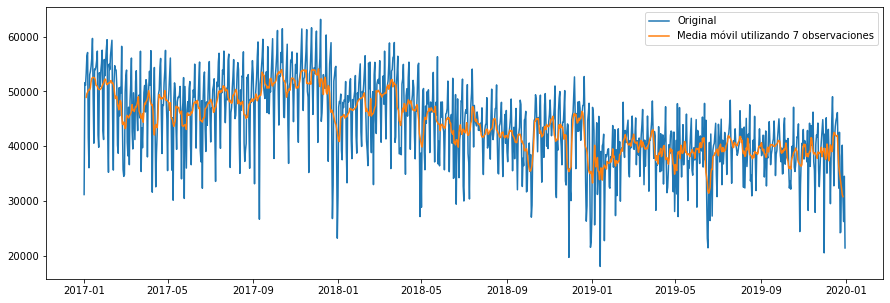

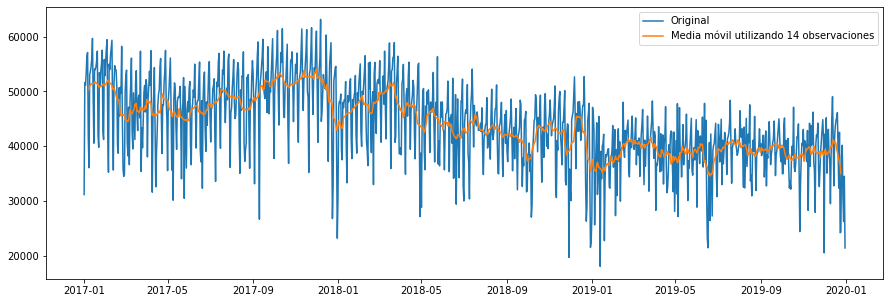

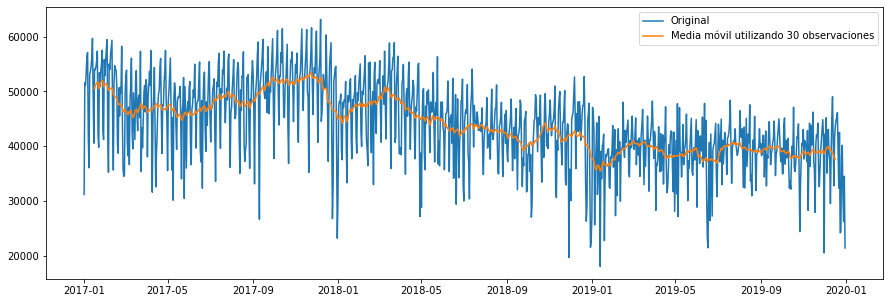

In [40]:
# Media movil
y_hat_avg = diario.copy()
y_hat_avg['moving_avg_forecast'] = diario['cantidad_pasos'].rolling(7,center = True).mean() 
# Promedio de las últimas 10 observaciones.
y_hat_avg=pd.DataFrame(y_hat_avg).set_index(diario.index.values)
plt.figure(figsize=(15,5)) 
plt.plot(diario['cantidad_pasos'], label='Original')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Media móvil utilizando 7 observaciones')
plt.legend(loc='best')
plt.show()

y_hat_avg = diario.copy()
y_hat_avg['moving_avg_forecast'] = diario['cantidad_pasos'].rolling(14,center = True).mean() 
# Promedio de las últimas 14 observaciones.
y_hat_avg=pd.DataFrame(y_hat_avg).set_index(diario.index.values)
plt.figure(figsize=(15,5))
plt.plot(diario['cantidad_pasos'], label='Original')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Media móvil utilizando 14 observaciones')
plt.legend(loc='best')
plt.show()

y_hat_avg = diario.copy()
y_hat_avg['moving_avg_forecast'] = diario['cantidad_pasos'].rolling(30,center = True).mean() 
# Promedio de las últimas 30 observaciones.
y_hat_avg=pd.DataFrame(y_hat_avg).set_index(diario.index.values)
plt.figure(figsize=(15,5))
plt.plot(diario['cantidad_pasos'], label='Original')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Media móvil utilizando 30 observaciones')
plt.legend(loc='best')
plt.show()

# Autocorrelacion

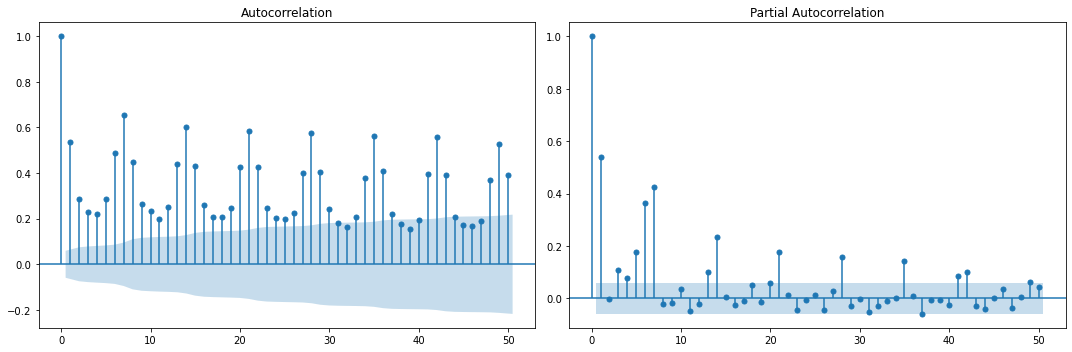

In [41]:
fig, axarr = plt.subplots(1,2,figsize=(15, 5))
plot_acf(diario.cantidad_pasos, lags = 50, ax=axarr[0])
plot_pacf(diario.cantidad_pasos, lags = 50,ax=axarr[1])
plt.tight_layout()
plt.show()

Podemos ver que existe un correlacion relevante para cada dia en un rango de 7 dias dentro de un periodo de 30 dias, que es refente a lo que dura un mes calendario. Es decir para poder estimar un dia, necesitamos los 7 anteriores y si queremos predecir una semana es necesario contar con 30 dias para lograr explicar los errores.

# Desconponiendo de la serie

Esta es una técnica que trata de descomponer una serie de tiempo en su tendencia, su estacionalidad y sus factores residuales. Statsmodels viene con una función de descomposición que nos facilita en sobremanera el trabajo.

In [42]:
#Calculamos la decomposición aditiva
additive_result = seasonal_decompose(diario.cantidad_pasos, model='additive', extrapolate_trend='freq')
#Calculamos la decomposición multiplicativa
mult_result = seasonal_decompose(diario.cantidad_pasos, model='multiplicative', extrapolate_trend='freq')

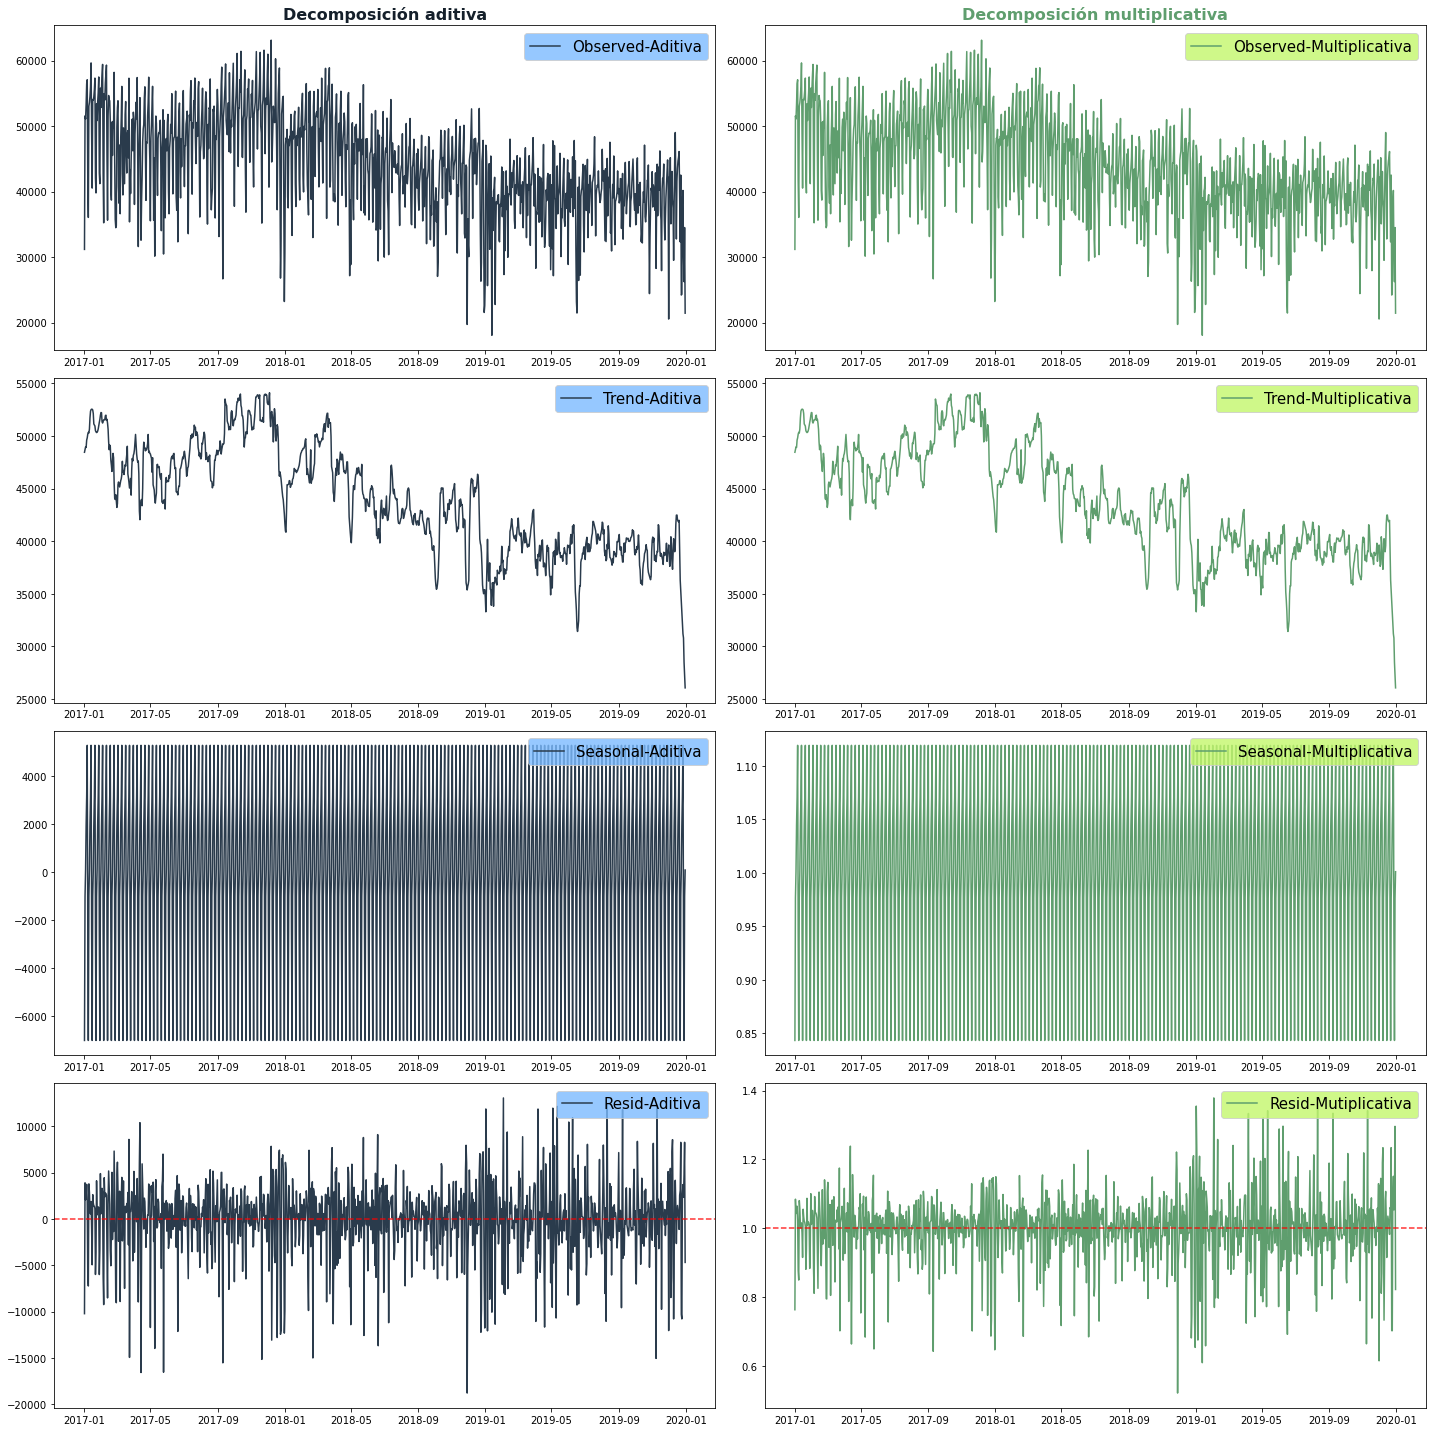

In [43]:
#Graficamos ambos casos para comparar

color_a='#2a3b4c'
color_m='#5f9e6e'

plt.figure(figsize=(20,20))
plt.subplot(421)
plt.title('Decomposición aditiva', fontweight='bold', fontsize=16, color='#15202b')
plt.plot(additive_result.observed, color=color_a, label= "Observed-Aditiva")
plt.legend(fontsize=15, facecolor= '#7cbbff', loc= 1)
plt.subplot(422)
plt.title('Decomposición multiplicativa', fontweight='bold', fontsize=16, color=color_m)
plt.plot(mult_result.observed, color=color_m, label= "Observed-Multiplicativa")
plt.legend(fontsize=15, facecolor= '#c4f76c', loc= 1)

plt.subplot(423)
plt.plot(additive_result.trend, color=color_a, label= "Trend-Aditiva")
plt.legend(fontsize=15, facecolor= '#7cbbff', loc= 1)
plt.subplot(424)
plt.plot(mult_result.trend, color=color_m, label= "Trend-Multiplicativa")
plt.legend(fontsize=15, facecolor= '#c4f76c', loc= 1)

plt.subplot(425)
plt.plot(additive_result.seasonal, color=color_a, label= "Seasonal-Aditiva")
plt.legend(fontsize=15, facecolor= '#7cbbff', loc= 1)
plt.subplot(426)
plt.plot(mult_result.seasonal, color=color_m, label= "Seasonal-Multiplicativa")
plt.legend(fontsize=15, facecolor= '#c4f76c', loc= 1)

plt.subplot(427)
plt.plot(additive_result.resid, color=color_a, label= "Resid-Aditiva")
plt.axhline(y=additive_result.resid.mean(), color='red', linestyle='--', alpha=0.8)
plt.legend(fontsize=15, facecolor= '#7cbbff', loc= 1)
plt.subplot(428)
plt.plot(mult_result.resid, color=color_m, label= "Resid-Mutiplicativa")
plt.axhline(y=mult_result.resid.mean(), color='red', linestyle='--', alpha=0.8)
plt.legend(fontsize=15, facecolor= '#c4f76c', loc= 1)

plt.tight_layout()
plt.show()


A primera vista, ambos modelos parecen ser similares.

La diferencia apreciable más importante a destacar es que los residuos del modelo aditivo tienen un comportamiento aleatorio con media 0, lo que nos puede indicar presencia de ruido blanco. Este comportamiento no ocurre en los residuos del modelo multiplicativo.

Para verificar si los datos observados son correctos y se acomodan a un comportamiento aditivo, se debería cumplir que: $Seasonal + Trend + Resid = Observed$. Si es multiplicativo, entonces $Seasonal * Trend + Resid = Observed$

Un comportamiento Aditivo supone que las observaciones se generan como suma de las cuatro componentes








### Comprobación - Comportamiento Aditivo¶


In [44]:
# Unimos los datasets con `axis=1`
cheking_aditiva = pd.concat([additive_result.seasonal,
                             additive_result.trend,
                             additive_result.resid,
                             additive_result.observed], axis=1)
# nombramos las columnas
cheking_aditiva.columns = ['seasonal', 'trend', 'resid', 'observed']
cheking_aditiva.head()

,seasonal,trend,resid,observed
fecha,,,,
2017-01-01,-7027.750168,48443.346939,-10232.596770,31183.0
2017-01-02,-1013.658343,48696.765306,3884.893036,51568.0
2017-01-03,86.779252,48950.183673,2056.037074,51093.0
2017-01-04,1937.920517,48904.285714,2489.793769,53332.0
2017-01-05,3161.985230,49601.714286,3722.300484,56486.0


In [45]:
# Escogemos una fecha aleatoria para hacer la prueba
random_date = datetime.datetime.strftime(pd.to_datetime(
    np.random.choice(cheking_aditiva.index)), '%Y-%m-%d')
# Guardamos cada uno de los valores en una variable:
trend = float(
    cheking_aditiva[cheking_aditiva.index == random_date].trend.values)
seasonal = float(
    cheking_aditiva[cheking_aditiva.index == random_date].seasonal.values)
resid = float(
    cheking_aditiva[cheking_aditiva.index == random_date].resid.values)
observed_value = float(
    cheking_aditiva[cheking_aditiva.index == random_date].observed.values)
# Realizamos la comprobación
if round(trend + seasonal + resid) == observed_value:
    print(
        f"Es un modelo aditivo: ({trend}) + ({seasonal}) + ({resid}) = {observed_value}")
else:
    print(
        f"No es un modelo aditivo: ({trend}) + ({seasonal}) + ({resid}) = {trend+seasonal+resid},\nEl valor observado realmente es {observed_value}")

Es un modelo aditivo: (53028.85714285714) + (5292.060016146165) + (2664.082840996697) = 60985.0


### Comprobación - Comportamiento Multiplicativo¶


In [46]:
cheking_mult = pd.concat([mult_result.seasonal,
                          mult_result.trend,
                          mult_result.resid,
                          mult_result.observed], axis=1)
cheking_mult.columns = ['seasonal', 'trend', 'resid', 'observed']
cheking_mult.head()

,seasonal,trend,resid,observed
fecha,,,,
2017-01-01,0.843375,48443.346939,0.763243,31183.0
2017-01-02,0.976538,48696.765306,1.084403,51568.0
2017-01-03,1.001023,48950.183673,1.042709,51093.0
2017-01-04,1.043994,48904.285714,1.044583,53332.0
2017-01-05,1.070275,49601.714286,1.064017,56486.0


In [47]:
#tres años, diario. ventana creada
#Center, me pone nulos al principio y al final.
ventana = int(360*3/30)
print(ventana)
diario_promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()
diario_promedio_tendencia

36


fecha
2017-01-01   NaN
2017-01-02   NaN
2017-01-03   NaN
2017-01-04   NaN
2017-01-05   NaN
              ..
2019-12-27   NaN
2019-12-28   NaN
2019-12-29   NaN
2019-12-30   NaN
2019-12-31   NaN
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

In [48]:
result = seasonal_decompose(diario.cantidad_pasos, model='aditive')

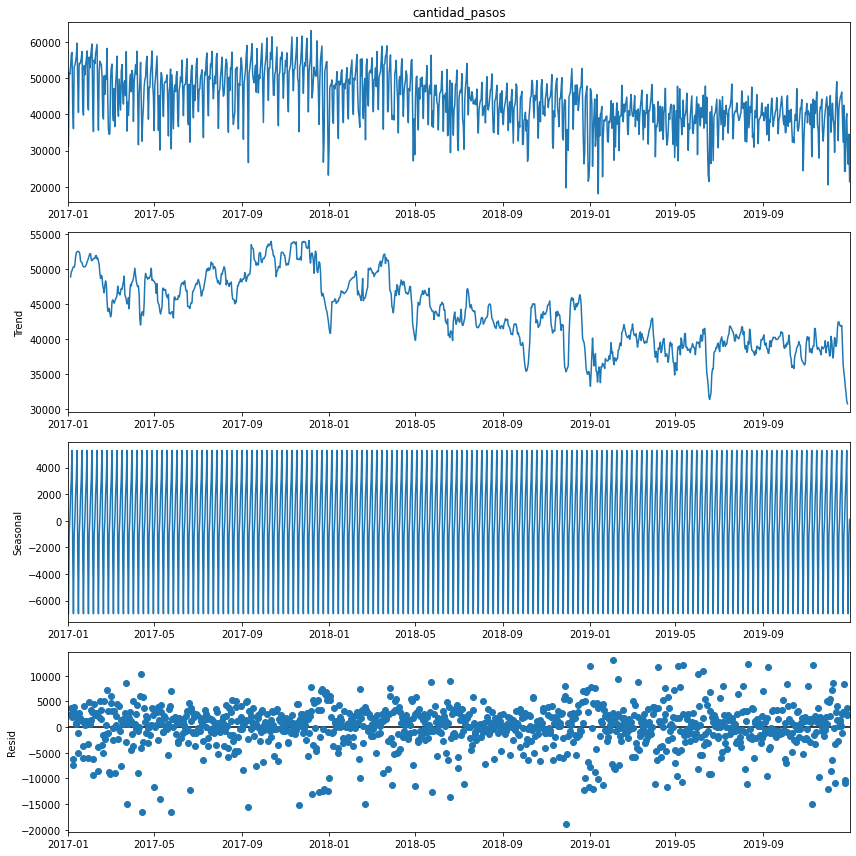

In [49]:
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()


El gráfico anterior muestra claramente que la cantidad de pasos es inestable, junto con su evidente estacionalidad, que es anual:

    En el primer gráfico vemos la serie tal como nos la presentan.
    
    Trend: vemos la tendencia de la serie, que ya hemos demostrado que es negativa.
    
    Seasonal: vemos la estacionalidad de la serie, que claramente es anual.
    
    Resid: vemos los residuas de la serie,se encuentran sin correlacion alguna y el promedio en general se encuentra fijo en 0 (cero), o sea denota Ruido Blanco. el ruido blanco es completamente aleatorio con una media de 0. En ruido blanco no hay patrón alguno.
    
    Sin embargo existe un dispersion del error que se aleja de madia lo que no es una buena opcion.

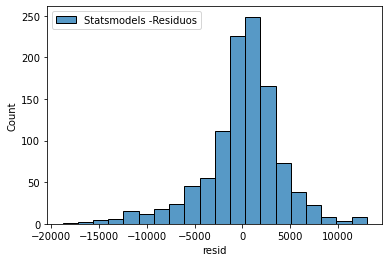

In [50]:
plt.figure(figsize = (6,4))
sns.histplot(result.resid, bins = 20, label="Statsmodels -Residuos")
plt.legend()
plt.show()

#### Comportamiento de la serie por rango horaio

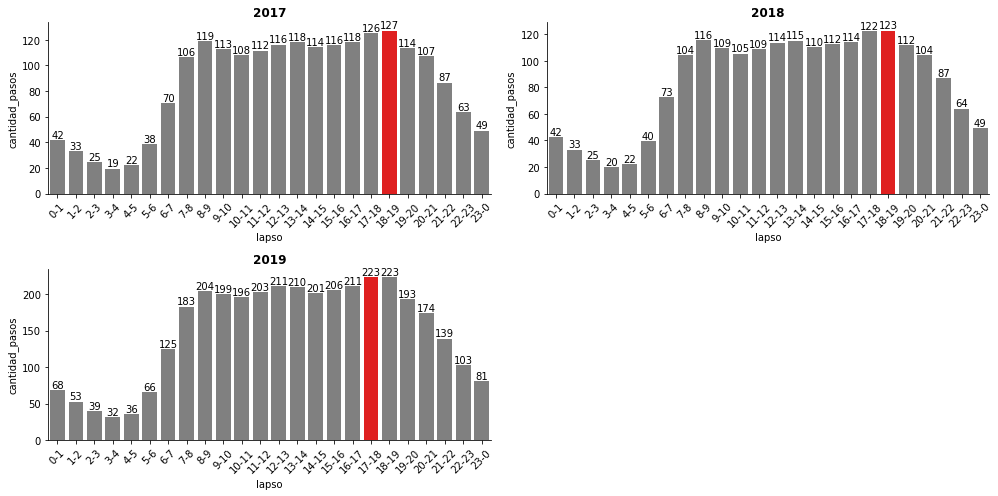

In [51]:
plt.figure(figsize=(14,7))
for idx,dataset in enumerate(datasets):
    pasos_horas=dataset.groupby(by=['hora_inicio','hora_fin']).agg('mean')[['cantidad_pasos']].reset_index()
    pasos_horas['hora_inicio']=pasos_horas['hora_inicio'].astype(str)
    pasos_horas['hora_fin']=pasos_horas['hora_fin'].astype(str)
    pasos_horas['lapso']= pasos_horas['hora_inicio']+'-'+pasos_horas['hora_fin']
    pasos_horas=pasos_horas.drop(columns=['hora_inicio','hora_fin']).set_index('lapso')
    plt.subplot(2,2,idx+1)
    pasos_hora_g=sns.barplot(x=pasos_horas.index,y='cantidad_pasos',data=pasos_horas,                           
                          palette=['grey' if (x < max(pasos_horas.cantidad_pasos)) else 'red' for x in pasos_horas.cantidad_pasos])
    plt.xticks(rotation=45,ha='center')    
    for p in pasos_hora_g.patches: 
        pasos_hora_g.annotate(format(p.get_height(), ',.0f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
    plt.title(f'{2017+idx}',fontweight='bold')
    sns.despine()
plt.tight_layout()
plt.show()

### Serie Semanal

In [52]:
#indicamos el dataset donde aplicamos la funcion
results_iqr_semanal = IQR(semanal)
IQR_semanal = results_iqr_semanal['IQR']
limite_sup_semanal = results_iqr_semanal['limite_sup']
limite_inf_semanal = results_iqr_semanal['limite_inf']
print('IQR Semanal')
print(results_iqr_semanal)

IQR Semanal
{'IQR': 58576.25, 'limite_sup': 422785.875, 'limite_inf': 188480.875}


In [53]:
semanal.describe()

,cantidad_pasos
count,158.000000
mean,302946.715190
std,47342.854449
min,31183.000000
25%,276345.250000
50%,307094.000000
75%,334921.500000
max,377832.000000


In [54]:
print('Cantidad de puntos por encima del límite superior:',semanal[semanal.cantidad_pasos>limite_sup_semanal].shape[0])
print('Cantidad de puntos por debajo del límite inferior:',semanal[semanal.cantidad_pasos<limite_inf_semanal].shape[0])
print(semanal[semanal.cantidad_pasos<limite_inf_semanal])

Cantidad de puntos por encima del límite superior: 0
Cantidad de puntos por debajo del límite inferior: 3
            cantidad_pasos
fecha                     
2017-01-01           31183
2018-12-02          180328
2020-01-05           55970


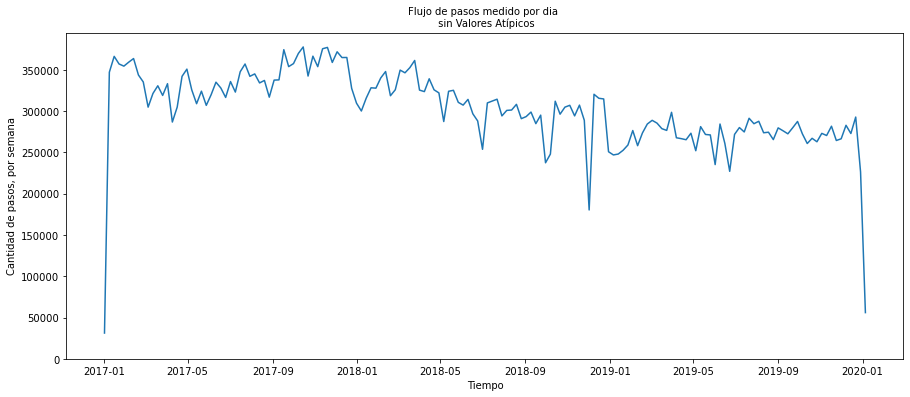

In [55]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.title("Flujo de pasos medido por dia \n sin Valores Atípicos", fontsize= 10)
plt.xlabel('Tiempo',)
plt.ylabel('Cantidad de pasos, por semana',)
plt.ylim(ymin=0)
plt.show()

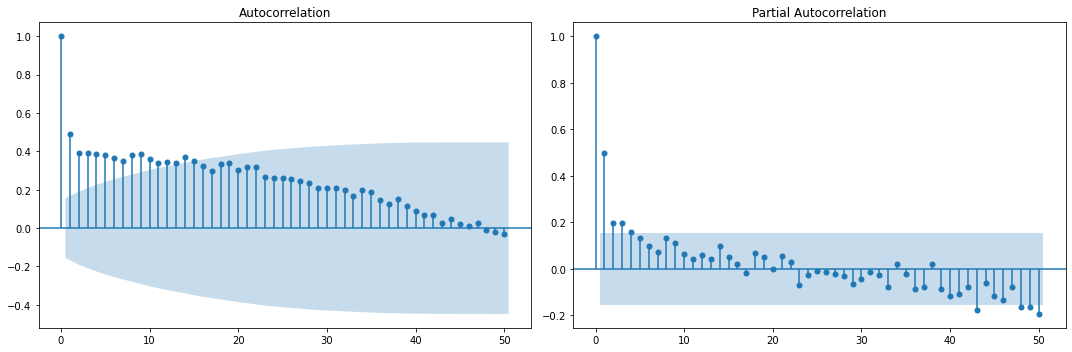

In [56]:
fig, axarr = plt.subplots(1,2,figsize=(15, 5))
plot_acf(semanal.cantidad_pasos, lags = 50, ax=axarr[0])
plot_pacf(semanal.cantidad_pasos, lags = 50,ax=axarr[1])
plt.tight_layout()
plt.show()

Autocorrelacion 15 - Auto correlacion parcial 4 a 4.5
Es decir para poder estimar un flujo semana, necesitamos las 15 semanas anteriores y si queremos predecir un mes es necesario contar con 4 a 5 semanas semanas para lograr explicar los errores.

#### Descomposición de la serie (semanal)¶

In [57]:
additive_result_week = seasonal_decompose(semanal.cantidad_pasos, model='additive', extrapolate_trend='freq')

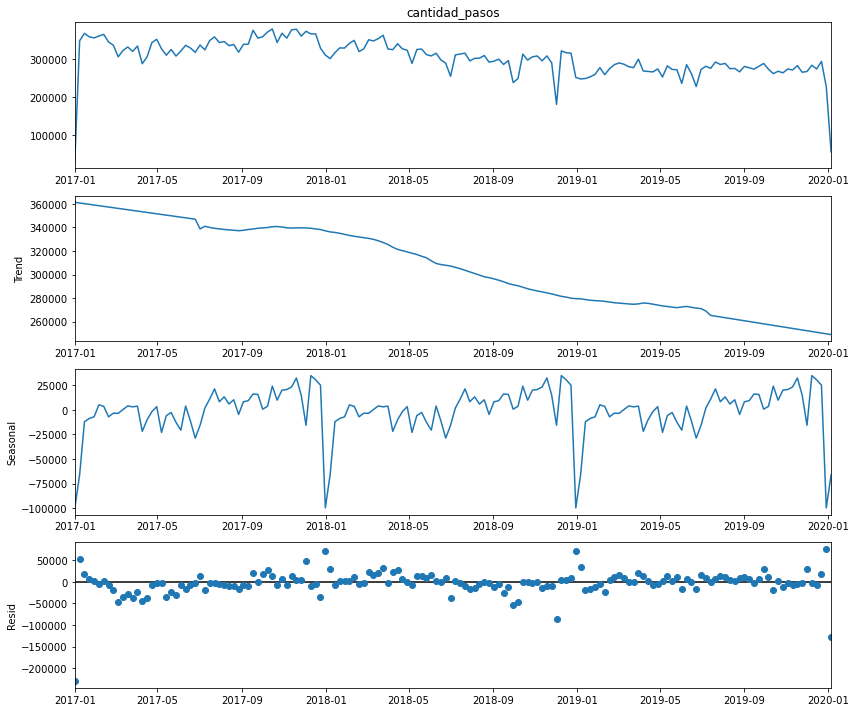

In [58]:
plt.rcParams['figure.figsize'] = [12,10]
additive_result_week.plot()
plt.show()

En el primer gráfico vemos la serie tal como nos la presentan.

Trend: vemos la tendencia de la serie, que ya hemos demostrado que es negativa y mas pronunciada

Seasonal: vemos la estacionalidad de la serie, que claramente es anual y mas marcada que una serie diaria

Resid: vemos los residuas de la serie,se encuentran sin correlacion alguna y el promedio en general se encuentra fijo en 0 (cero), o sea denota Ruido Blanco. el ruido blanco es completamente aleatorio con una media de 0. En ruido blanco no hay patrón alguno.

En este caso el error se encuentrar mas cercanos a la media cero lo que nos permitiria tener una estimacion algo mas precisa sin embargo es importante mencionar que para este caso perdemos la posibilidad de estimar dias puntales.

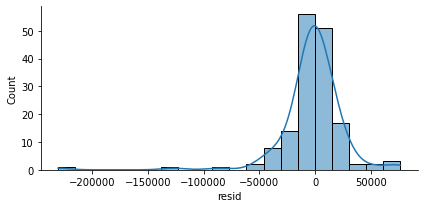

In [59]:
sns.displot(additive_result_week.resid,bins=20, kde=True, height=3, aspect=2)
plt.show()

#### Para poder trabajar con series de tiempo de manera correcta es necesrio eliminar los extremos cero.

In [60]:
#Mascara para elimar los extremos que tienden a cero
semanal_m=semanal[(semanal.index >='2017-01-08')&(semanal.index <='2019-12-29')]
semanal_m

,cantidad_pasos
fecha,
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581
2017-02-05,359401
...,...
2019-12-01,266555
2019-12-08,282891
2019-12-15,272960


In [61]:
semanal_m.describe()

,cantidad_pasos
count,156.000000
mean,306271.974359
std,37270.877679
min,180328.000000
25%,276677.500000
50%,307243.000000
75%,335209.000000
max,377832.000000


#### Mejorando a serie Semanal

In [62]:
senial= semanal_m.cantidad_pasos
senial.shape

(156,)

In [63]:
look_back= 15 # Numero de semanas que voy a usar para predecir el valor siguiente.

N= senial.shape[0]
X= np.zeros((N - look_back - 1, look_back))
Y= np.zeros(N - look_back - 1)

print(X.shape, Y.shape)

(140, 15) (140,)


In [64]:
for i in range(X.shape[0]):
    
    X[i,:] = senial.iloc[i:i+look_back]
    Y[i] = senial.iloc[i+look_back]

In [65]:
print(X, X.shape)
print("----------------------------------------------------------------------")
print(Y, Y.shape)

[[347212. 366413. 357215. ... 333297. 286862. 304912.]
 [366413. 357215. 354581. ... 286862. 304912. 342225.]
 [357215. 354581. 359401. ... 304912. 342225. 350946.]
 ...
 [265594. 279775. 276271. ... 281790. 264500. 266555.]
 [279775. 276271. 272592. ... 264500. 266555. 282891.]
 [276271. 272592. 279927. ... 266555. 282891. 272960.]] (140, 15)
----------------------------------------------------------------------
[342225. 350946. 325875. 309072. 324240. 307054. 319937. 335147. 328122.
 316651. 335900. 323159. 347770. 357156. 342240. 345164. 334245. 337243.
 316987. 337659. 337933. 374520. 353999. 357671. 369918. 377832. 342571.
 366650. 353947. 375644. 377263. 359053. 371970. 364991. 365063. 327602.
 309692. 300242. 315780. 328359. 327887. 340275. 348044. 318733. 325966.
 349768. 346506. 352713. 361465. 325545. 323725. 339255. 325904. 322154.
 287470. 324115. 325304. 310709. 307369. 314291. 296834. 288154. 253807.
 310012. 312335. 314517. 294270. 300955. 301407. 308307. 290940. 293436.

In [66]:
N_train = 143 - look_back        # Cantidad de semanas que uso para entrenar
N_test = 12                      # Cantidad de semanas que uso para evaluar.

N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = Y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = Y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(128, 15) (128,)
(12, 15) (12,)


### RandomForestRegressor

In [67]:
rf = RandomForestRegressor( random_state=42, n_jobs = -1)

In [68]:
rf.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

### Prediciendo

In [69]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

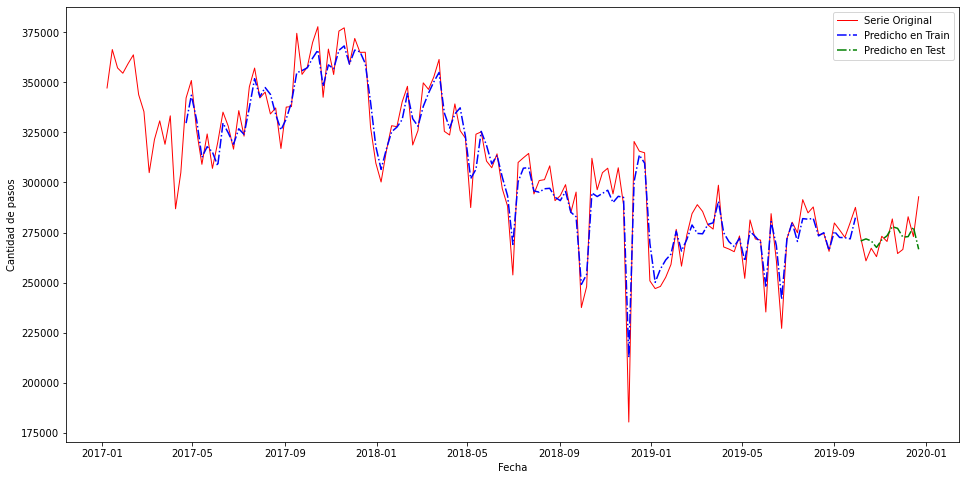

RMSE RFR en Train: 8229.748193082682
RMSE RFR en Test: 9964.548007357138


In [70]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse =np.sqrt( mean_squared_error(y_train, y_train_pred))
print('RMSE RFR en Train:',rmse)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('RMSE RFR en Test:',rmse)

#### En esta primera etapa nuestro error en train es de 8229  pasos y en el caso de Test sube a 10.000 pasos. semanales.

    Es importante mecionar que el caso de una serie semanal el minimo esta cercano a 180.328
    
    En este caso contamos con algunos sesgos en nuestras metricas sin embargo resultan ser bastante bajas para las caracteristicas de los datos.
    
    
  *Importante mencionar que en este caso los hiperparametros estan dados por defecto.
    

#### Optimizando hiperparametros

In [71]:
tss= TimeSeriesSplit(n_splits=2)

In [72]:
param_grid = {'n_estimators':[ 20, 50,100,200],
              'max_depth': [i for i in range(2,20)],
              'max_features': ['auto', 'sqrt', 'log2'], 
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 6]} 
rf_reg=RandomForestRegressor(random_state=42)
rf_gs =GridSearchCV(rf_reg, param_grid, scoring='neg_root_mean_squared_error', cv=tss,verbose=5,n_jobs=-1)

In [73]:
rf_gs.fit(X_train,y_train)

Fitting 2 folds for each of 2592 candidates, totalling 5184 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [74]:
rf_gs.best_params_

{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}

Aplicando los hiperparametros

In [75]:
rf_h = RandomForestRegressor(max_depth= 4,
                             max_features= 'auto',
                             n_estimators= 20,
                             random_state=42,
                             min_samples_leaf=6,
                             min_samples_split= 2)

In [76]:
rf_h.fit(X_train,y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=6, n_estimators=20,
                      random_state=42)

In [77]:
y_train_pred = rf_h.predict(X_train)
y_test_pred = rf_h.predict(X_test)

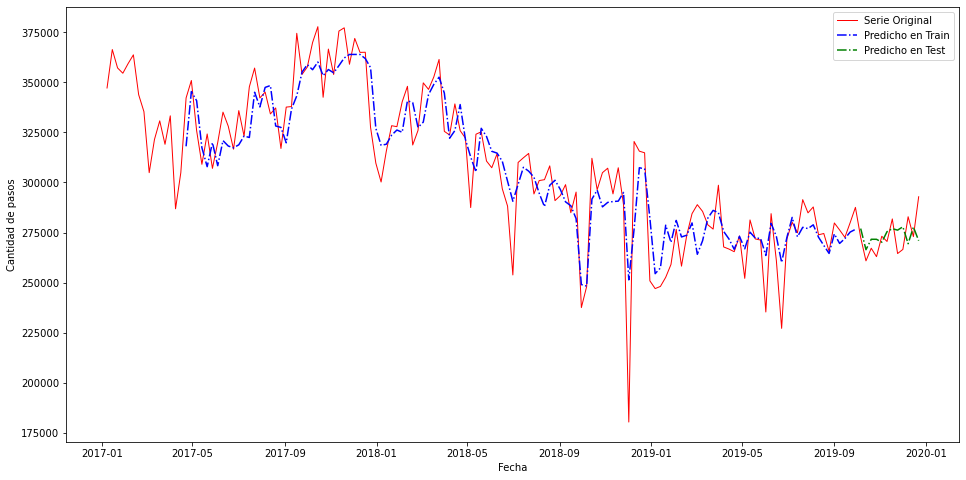

RMSE RFR_op en Train: 14830.7678070758
RMSE RFR_op en Test: 9804.584611918148


In [78]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('RMSE RFR_op en Train:',rmse)

rmse =np.sqrt( mean_squared_error(y_test, y_test_pred))
print('RMSE RFR_op en Test:',rmse)

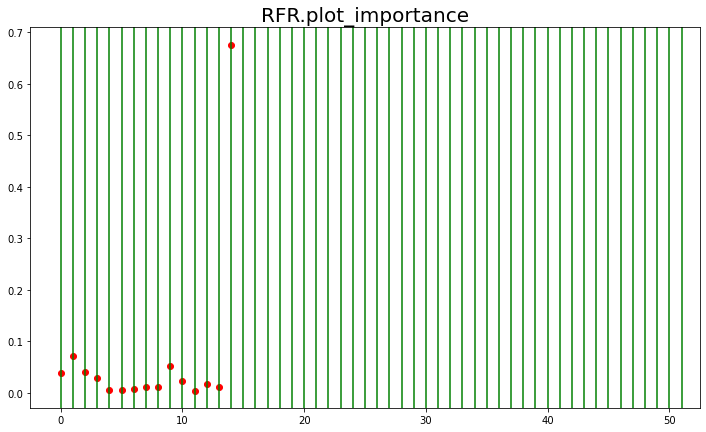

In [79]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf_h.feature_importances_.size),rf_h.feature_importances_,color='red')
plt . title ( "RFR.plot_importance", size=20 ) 
for x in range(52):
    plt.axvline(x, linestyle ='-', color= 'green')
plt.show()

### XGBRegressor

In [80]:
xgb_h_1=XGBRegressor(colsample_bytree=1,
                   learning_rate= 0.3,
                   max_depth= 5,
                   min_child_weight= 3,
                   n_estimators= 20,
                   nthread= 4,
                   objective= 'reg:squarederror',
                   n_jobs = -1,
                   random_state=42,
                   reg_lambda= 1,
                   subsample= 0.5)

In [81]:
xgb_h_1.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, nthread=4, num_parallel_tree=1,
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.5, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [82]:
y_train_pred = xgb_h_1.predict(X_train)
y_test_pred = xgb_h_1.predict(X_test)

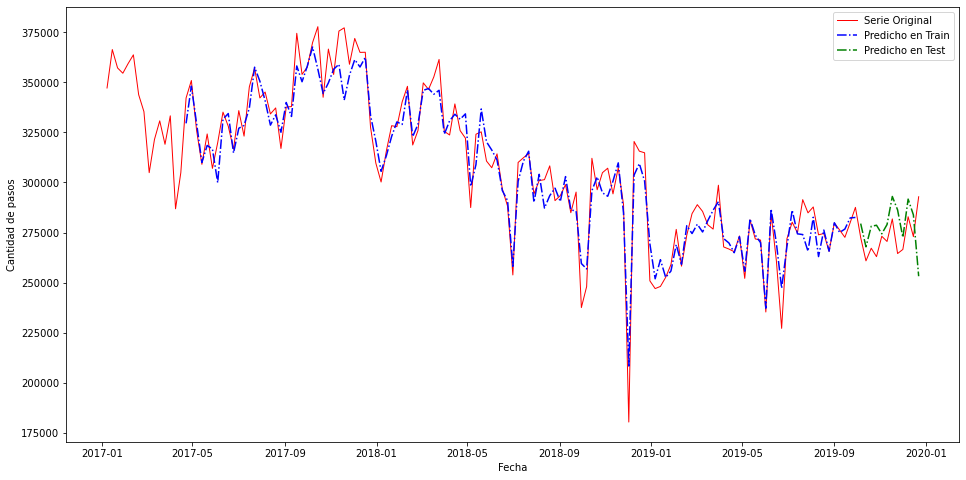

RMSE XGB en Train: 9458.924662921561
RMSE XGB en Test: 15667.980466045363


In [83]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('RMSE XGB en Train:',rmse)

rmse_xgb =np.sqrt( mean_squared_error(y_test, y_test_pred))
print('RMSE XGB en Test:',rmse_xgb)

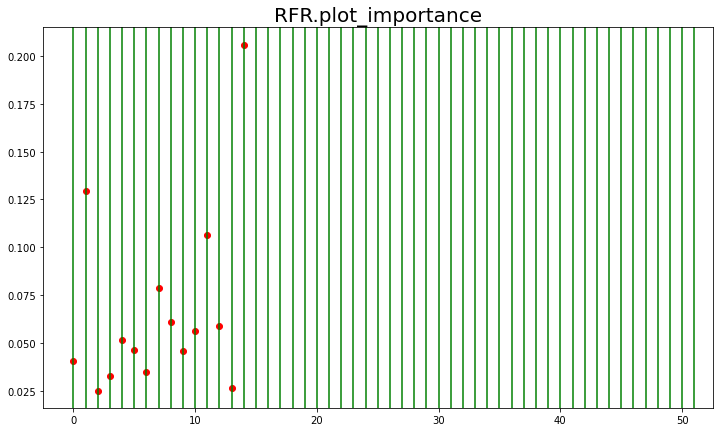

In [84]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(xgb_h_1.feature_importances_.size),xgb_h_1.feature_importances_,color='red')
plt . title ( "RFR.plot_importance", size=20 ) 
for x in range(52):
    plt.axvline(x, linestyle ='-', color= 'green')
plt.show()

        ### El modelo tiene a dar mayor relavancia a los datos entre la primera semana y la semana once.

## Resultados de los modelos

#### RamdonForest 
    RMSE train 8229
    RMSE test  9964
#### Rf_op  
    RMSE train 0.14
    RMSE test 14083
    
#### XGB
    RMSE train 9458
    RMSE test 15667
    
    
##### En relacion a los resultados podemos establecer que el modelo con menor sesgo es RF sin optimizar, sin embargo un modelo XGB tampoco presenta malas metricas, considerando que contamos con herramientas para reducir el sesgo y la varianza.

# Predicción año 2020

In [92]:
data_2020 = pd.read_csv(r'flujo-vehicular-2020.csv', sep =',')

In [93]:
data_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         float64
 1   fecha           object 
 2   mes             object 
 3   dia             object 
 4   dia_fecha       float64
 5   hora_inicio     float64
 6   hora_fin        float64
 7   estacion        object 
 8   tipo_vehiculo   object 
 9   forma_pago      object 
 10  observacion     object 
 11  sentido         object 
 12  cantidad_pasos  float64
dtypes: float64(5), object(8)
memory usage: 251.3+ MB


In [94]:
data_2020.forma_pago.replace({'Efectivo':'EFECTIVO','Tarjeta Magnética':'TELEPASE','Tag':'TELEPASE'},
                             inplace=True)

In [95]:
data_2020.estacion.replace({'ALBERDI':'Alberdi','AVELLANEDA':'Avellaneda','ILLIA':'Illia','RETIRO':'Retiro',
                            'SARMIENTO':'Sarmiento','SALGUERO':'Salguero','DELLEPIANE LINIERSLEPIANE CENTRO':
                           'Dellepiane Centro','DELLEPIANE LINIERS':'Dellepiane Liniers'},inplace=True)


In [96]:
data_2020.tipo_vehiculo.replace({'Pesado 2 Ejes':'Pesado','Pesado 3 Ejes':'Pesado','Pesado 4 Ejes':'Pesado',
                                 'Pesado 5 Ejes':'Pesado','Pesados 6 Ejes':'Pesado'})

0            Auto
1            Auto
2            Auto
3            Auto
4            Auto
            ...  
2533738    Pesado
2533739    Pesado
2533740    Pesado
2533741    Pesado
2533742    Pesado
Name: tipo_vehiculo, Length: 2533743, dtype: object

In [97]:
data_2020.drop(columns=['mes','dia','observacion','dia_fecha'], inplace = True)

#### Trabajaremos con ellia y pago e efectivo.

In [98]:
#Unimos los 4 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2020,data_2019, data_2018, data_2017])
#Nos quedamos solamente con la estación Illia y la forma de pago telepase
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'TELEPASE')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_t = dataset.resample('D', on = 'fecha').sum()
print(diario_t.shape)
diario_t.head()

(1461, 1)


,cantidad_pasos
fecha,
2017-01-01,12326.0
2017-01-02,35621.0
2017-01-03,39390.0
2017-01-04,40294.0
2017-01-05,41373.0


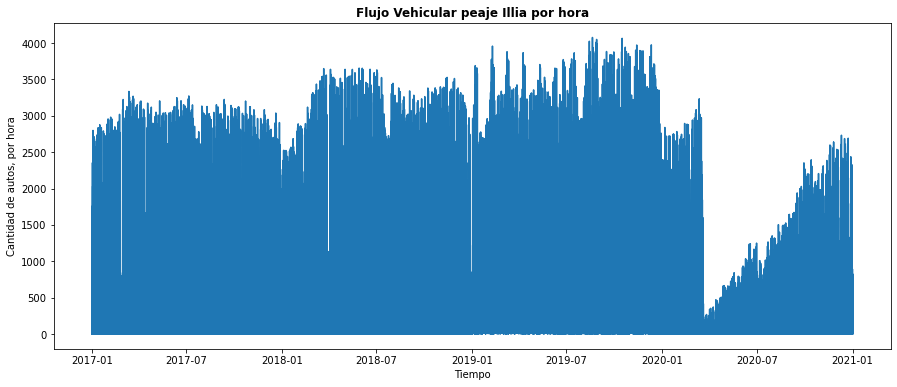

In [99]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.title ('Flujo Vehicular peaje Illia por hora', fontweight = 'black')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [100]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1461, 1)


,cantidad_pasos
fecha,
2017-01-01,12326.0
2017-01-02,35621.0
2017-01-03,39390.0
2017-01-04,40294.0
2017-01-05,41373.0


In [101]:
diario.cantidad_pasos.isnull().sum()

0

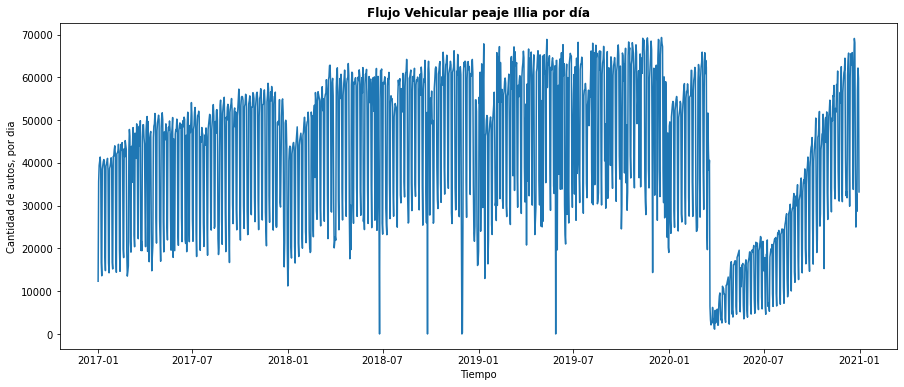

In [102]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.title ('Flujo Vehicular peaje Illia por día', fontweight = 'black')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [103]:
diario.tail()

,cantidad_pasos
fecha,
2020-12-27,28674.0
2020-12-28,56887.0
2020-12-29,62193.0
2020-12-30,59739.0
2020-12-31,33206.0


In [104]:
look_back = 90*1 # usamos x días de datos para predecir el valor siguiente

In [105]:
N = diario.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1370, 90) (1370,)


In [106]:
N-365-1

1095

In [107]:
for i in range(X.shape[0]):
    X[i,:] = diario.values[i:i+look_back].ravel()
    y[i] = diario.values[i+look_back]

In [108]:
N_train = 2*365 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 1*365 # cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(640, 90) (640,)
(365, 90) (365,)


In [109]:
N_total

1005

#### Modelo Benchmark 2020

In [110]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

In [111]:
y_test_pred_benchmark.shape

(365,)

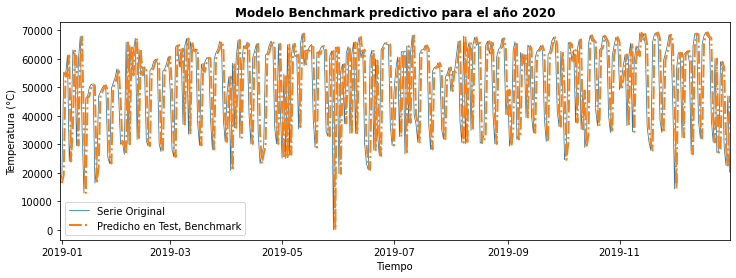

In [112]:
plt.figure(figsize=(12,4))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(diario.index[N_train+look_back-1], diario.index[length_total-1])
plt.title ('Modelo Benchmark predictivo para el año 2020', fontweight = 'black')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

In [126]:
from sklearn.metrics import mean_squared_error
rmse =np.sqrt( mean_squared_error(y_train, y_train_pred))
print('RMSE RFR en Train:',rmse)

RMSE RFR en Train: 3045.287980699547


In [114]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

In [115]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [116]:
diario.index[N_train+look_back: length_total].shape

(365,)

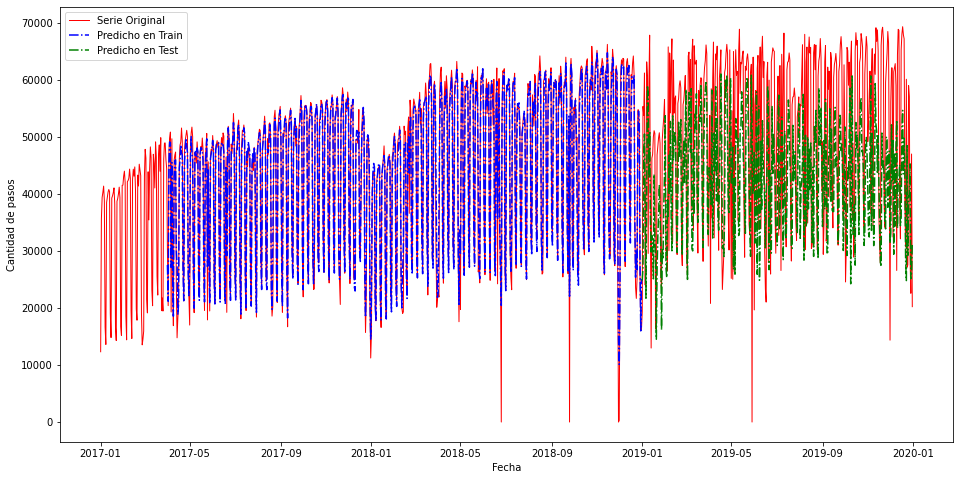

RMSE RFR en Train: 3045.287980699547
RMSE RFR en Test: 17698.652607374057


In [122]:
plt.figure(figsize=(16,8))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(diario.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(diario.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse =np.sqrt( mean_squared_error(y_train, y_train_pred))
print('RMSE RFR en Train:',rmse)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('RMSE RFR en Test:',rmse)

### Resultados de los modelos

    RamdonForest
    RMSE train 8229
    RMSE test  9964

    RamdonForest 2.0
    RMSE Train: 3045
    RMSE Test: 17698

# Conclusiones Generales

    Cuando analizamos los períodos precios al año 2020, consideramos eliminar aquellos valores por debajo de 1000 pasos con el objetivo de tener una serie limpia para la predicción. Sin embargo el año 2020 supuso en sus inicios una baja considerable en el tráfico de las ciudades en la medida que las restricciones sanitarias productos de la pandemia buscaban reducir la movilidad. Es por eso que para la estimación del año 2020 determinamos no eliminar esos datos menos a mil, dado que es posible que esto sacuda y es si bien nos ayuda para reducir el error es importantes para ayudar al modelo a entender el comportamiento.

    Sin embargo vemos que en la medida que le entregamos datos atípicos al modelo su sesgo y varianza se acentúan, pero es totalmente posible reducirlo con un preproceso que nos ayude al modelo saber cuando se encuentra frente a un momento atípico como pueden ser feriados, situaciones sanitarias adversas, clima o incentivos económicos.

    En este sentido es importante mencionar que desde el año 2001 la Argentina guió una serie de reformas en el sistema de concesiones viales, lo que impulsó el desarrollo del polo de autopista que conecta el Gran Buenos Aires. Es por esa razón que la cantidad de pagos efectuados en efectivo tiene un fuerte desincentivo por parte de los agentes. Esto se encuentra enmarcado en un profundo cambio en los objetivos administrativos locales.

    En tanto es importante mencionar que el incentivo para el uso de pagos electrónicos que incorpora ciertas mejoras en los tiempos de traslado no ha tenido un aumento sustancial en su uso esto a razón del estancamiento del parque automotriz asociado a factores económicos consecuencia de la profunda crisis económica que afecta al país.

    Por otro lado el gobierno lleva por delante un plan de Movilidad Sostenible que busca reordenar el tránsito, para que todos podamos trasladarnos de manera rápida, segura y ordenada en nuestra Ciudad, contribuyendo además a una mejor calidad ambiental.
    
 #### Finalmente es claro el cambio en la manera que los usuarios pagar el usos de las autopistas, lo que es importante de estimar en función de los flujos de caja los que se verá afectado considerando que el pago electrónico por el momento no es un cobro instantáneo a las cuentas de los usuarios sino que es cargado posterior el curso respectivo, lo que provocará un desfase en los ingresos de la empresas administradora que además debe por ley reinvertir un % de ellos en el desarrollo y mejoras de las autopistas adjudicadas.


### LEONARDO GONZALEZ J.

Ingeniero en Negocio - Economía
2012 Universidad Catolica Silva Henriquez..

Magister Politicas Publicas
2014 Universidad Diego Portales (congelado)

Desarrollo Front End
2020 Coding Dojo - Yellow Belt

Data Science
2021 Acamica - Digital House.

